In [1]:
from distributed import Client

# Connect to cluster
client = Client()
client.dashboard_link

/home/eva/miniforge-pypy3/envs/councils-in-action/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33579 instead
  warnings.warn(


'http://127.0.0.1:33579/status'

In [2]:
import dask.dataframe as dd

# Read count data
counts = dd.read_parquet("councils-in-action-ds/raw-counts/*")
counts = counts.persist()
counts

,ngram,count_,percent_of_total,session_datetime,council
npartitions=495,,,,,
,object,int64,float64,"datetime64[ns, UTC]",object
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [3]:
# Setup for plotting
import seaborn as sns
from cdp_data.plots import set_cdp_plotting_styles
from nltk.stem.snowball import SnowballStemmer

# Standard styling
set_cdp_plotting_styles()

# Stem words before counting
stemmer = SnowballStemmer("english")

def plot_ngrams(data, terms):
    stemmed_grams = [stemmer.stem(term) for term in terms]
    subset = data[data.ngram.isin(stemmed_grams)]
    ax = sns.relplot(
        data=subset,
        x="session_datetime",
        y="percent_of_total",
        hue="ngram",
        col="council",
        col_wrap=3,
        kind="line",
    )
    ax.tick_params(axis="x", rotation=45)

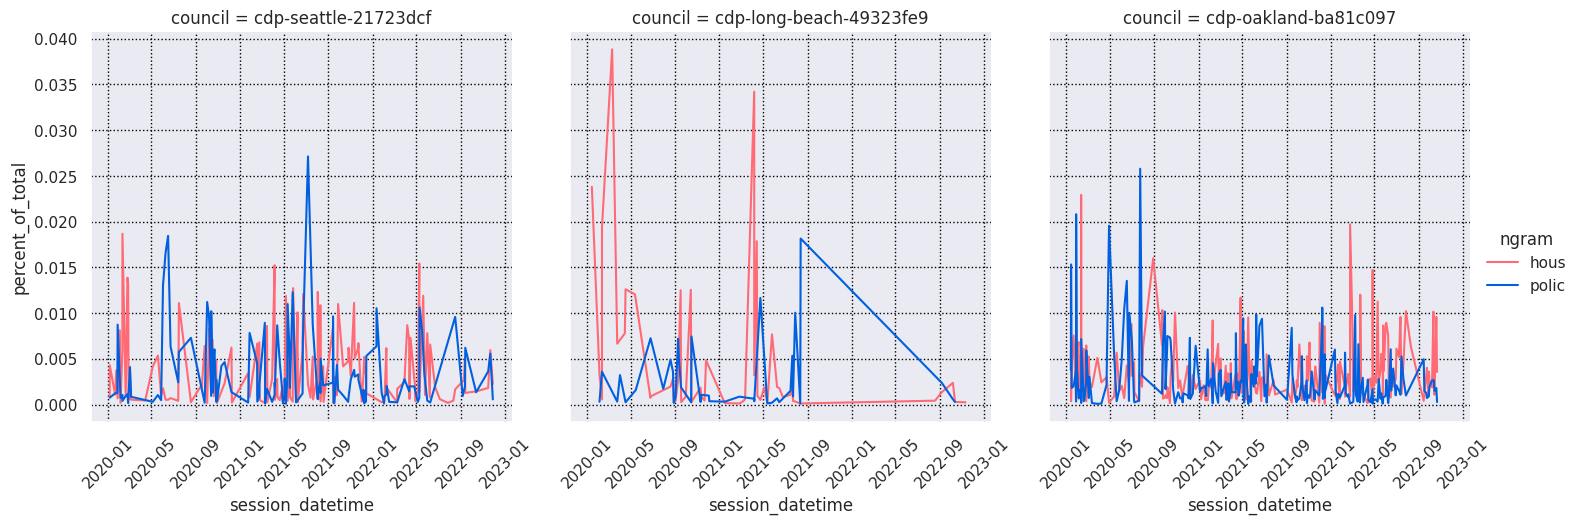

In [4]:
plot_ngrams(counts, ["police", "housing"])